In [1]:
!pip install nengo --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 5.3 MB/s eta 0:00:00


In [2]:
!pip install nengo-dl --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install nengo-loihi --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 kB 3.2 MB/s eta 0:00:00


In [8]:
%matplotlib inline

from collections import deque

import matplotlib.pyplot as plt
import numpy as np

import nengo
import nengo_loihi

In [9]:
# parameters of LMU
theta = 1.0  # length of window (in seconds)
order = 6  # number of Legendre polynomials representing window

# parameters of input signal
freq = 2  # frequency limit
rms = 0.30  # amplitude of input (set to keep within [-1, 1])
delay = 0.5  # length of time delay network will learn

# simulation parameters
dt = 0.001  # simulation timestep
sim_t = 30  # length of simulation
seed = 10  # fixed for deterministic results

In [10]:
# compute the A and B matrices according to the LMU's mathematical derivation
# (see the paper for details)
Q = np.arange(order, dtype=np.float64)
R = (2 * Q + 1)[:, None] / theta
j, i = np.meshgrid(Q, Q)

A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
B = (-1.0) ** Q[:, None] * R

ERROR:nengo.cache:Decoder cache index corrupted. Reinitializing cache.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/nengo/cache.py", line 462, in __enter__
    self._load_index_file()
  File "/usr/local/lib/python3.10/dist-packages/nengo/cache.py", line 385, in _load_index_file
    with self.index_path.open("rb") as f:
  File "/usr/lib/python3.10/pathlib.py", line 1119, in open
    return self._accessor.open(self, mode, buffering, encoding, errors,
FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/nengo/decoders/index'


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

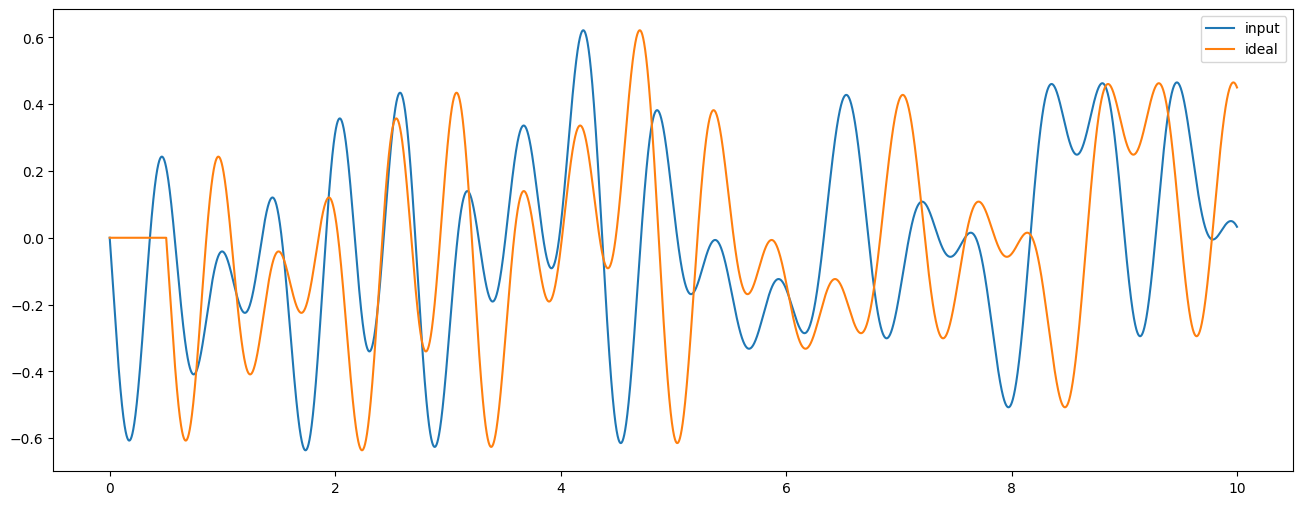

In [11]:
class IdealDelay(nengo.synapses.Synapse):
    def __init__(self, delay):
        super().__init__()
        self.delay = delay

    def make_state(self, *args, **kwargs):  # pylint: disable=signature-differs
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state):
        # buffer the input signal based on the delay length
        buffer = deque([0] * int(self.delay / dt))

        def delay_func(t, x):
            buffer.append(x.copy())
            return buffer.popleft()

        return delay_func


with nengo.Network(seed=seed) as net:
    # create the input signal
    stim = nengo.Node(
        output=nengo.processes.WhiteSignal(
            high=freq, period=sim_t, rms=rms, y0=0, seed=seed
        )
    )

    # probe input signal and an ideally delayed version of input signal
    p_stim = nengo.Probe(stim)
    p_ideal = nengo.Probe(stim, synapse=IdealDelay(delay))

# run the network (on the superhost) and display results
with nengo.Simulator(net) as sim:
    sim.run(10)

    plt.figure(figsize=(16, 6))
    plt.plot(sim.trange(), sim.data[p_stim], label="input")
    plt.plot(sim.trange(), sim.data[p_ideal], label="ideal")
    plt.legend()

In [12]:
with net:
    nengo_loihi.set_defaults()

    lmu = nengo.networks.EnsembleArray(
        n_neurons=100, n_ensembles=order, neuron_type=nengo.SpikingRectifiedLinear()
    )
    tau = 0.1  # synaptic filter on LMU connections
    nengo.Connection(stim, lmu.input, transform=B * tau, synapse=tau)
    nengo.Connection(
        lmu.output, lmu.input, transform=A * tau + np.eye(order), synapse=tau
    )

In [13]:
with net:
    ens = nengo.Ensemble(1000, order, neuron_type=nengo.SpikingRectifiedLinear())
    nengo.Connection(lmu.output, ens)

    out = nengo.Node(size_in=1)

    # we'll use a Node to compute the error signal so that we can shut off
    # learning after a while (in order to assess the network's generalization)
    err_node = nengo.Node(lambda t, x: x if t < sim_t * 0.8 else 0, size_in=1)

    # the target signal is the ideally delayed version of the input signal,
    # which is subtracted from the ensemble's output in order to compute the
    # PES error
    nengo.Connection(stim, err_node, synapse=IdealDelay(delay), transform=-1)
    nengo.Connection(out, err_node, synapse=None)

    learn_conn = nengo.Connection(
        ens, out, function=lambda x: 0, learning_rule_type=nengo.PES(5e-4)
    )
    nengo.Connection(err_node, learn_conn.learning_rule, synapse=None)

    p_out = nengo.Probe(out)

/usr/local/lib/python3.10/dist-packages/nengo_loihi/builder/discretize.py:481: UserWarning: Lost 3 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/usr/local/lib/python3.10/dist-packages/nengo_loihi/builder/discretize.py:481: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/usr/local/lib/python3.10/dist-packages/nengo_loihi/builder/discretize.py:481: UserWarning: Lost 2 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/usr/local/lib/python3.10/dist-packages/nengo_loihi/builder/discretize.py:481: UserWarning: Lost 4 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


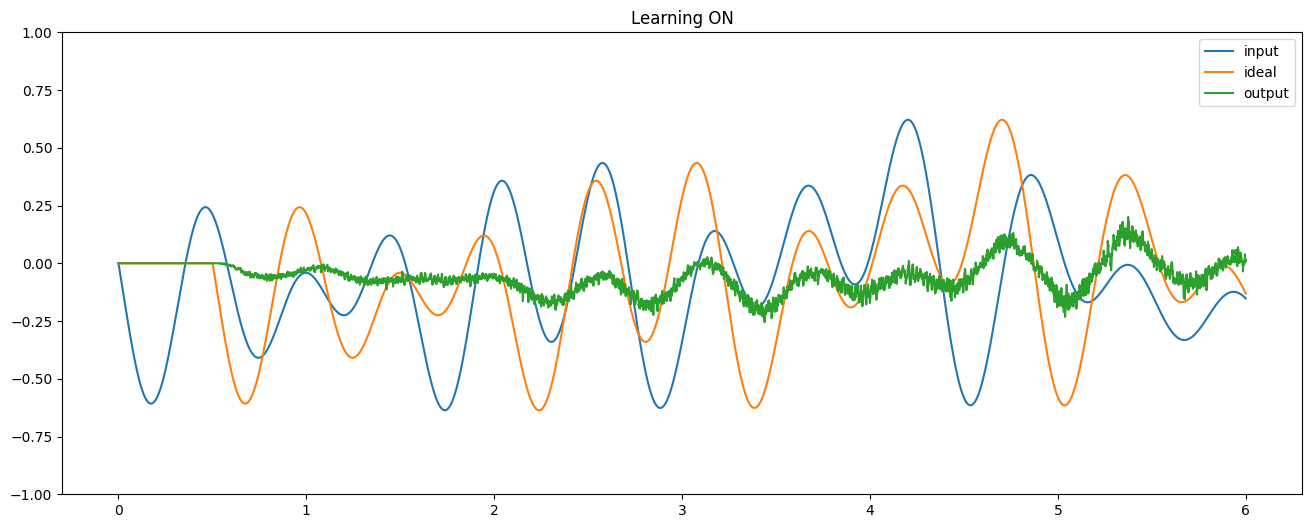

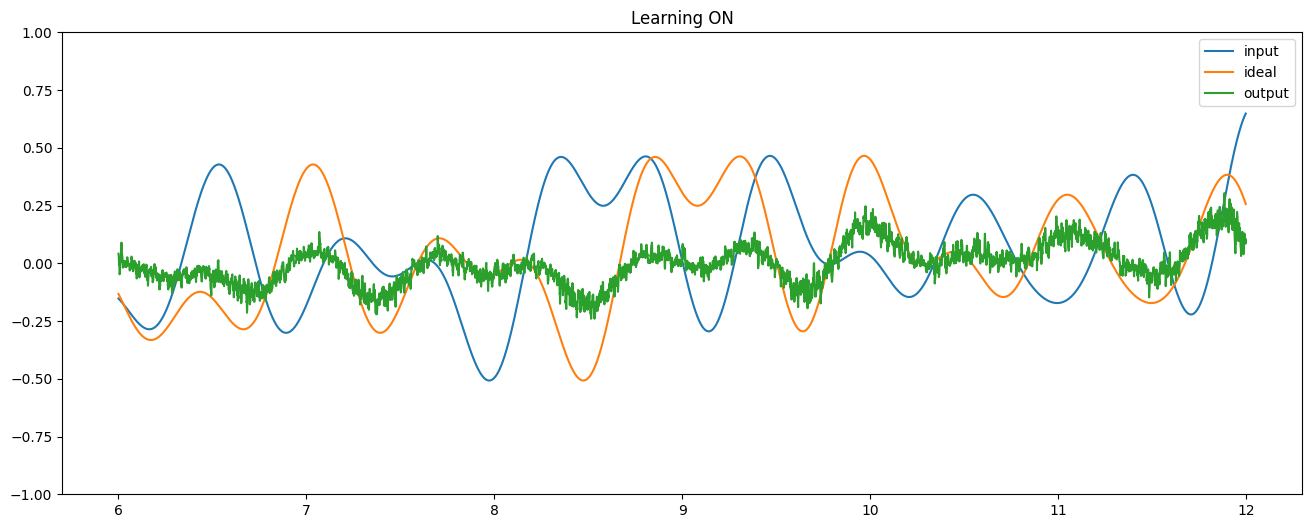

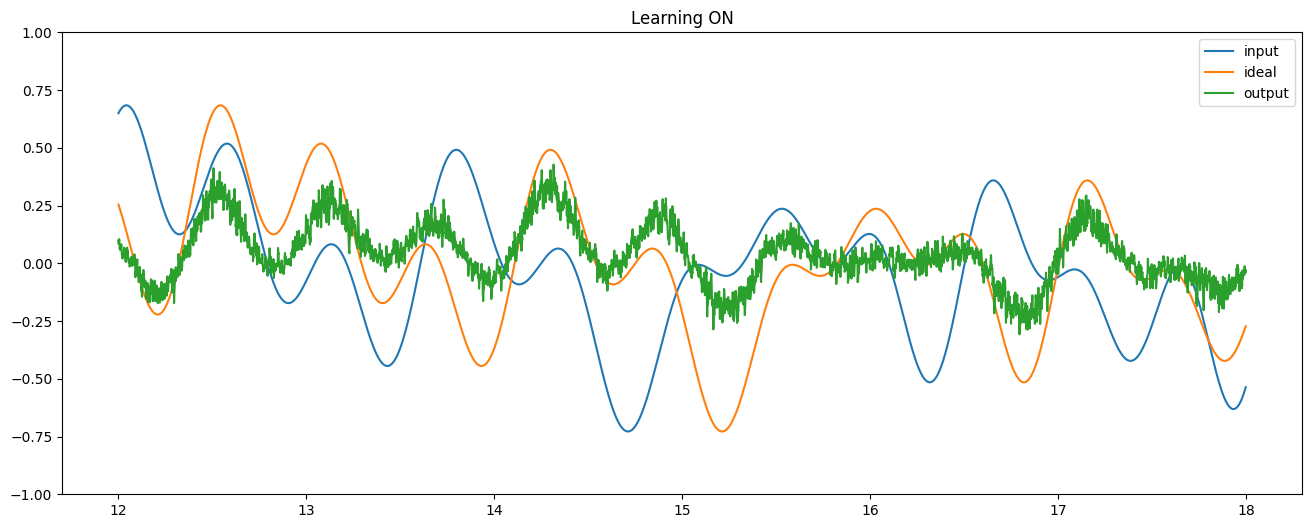

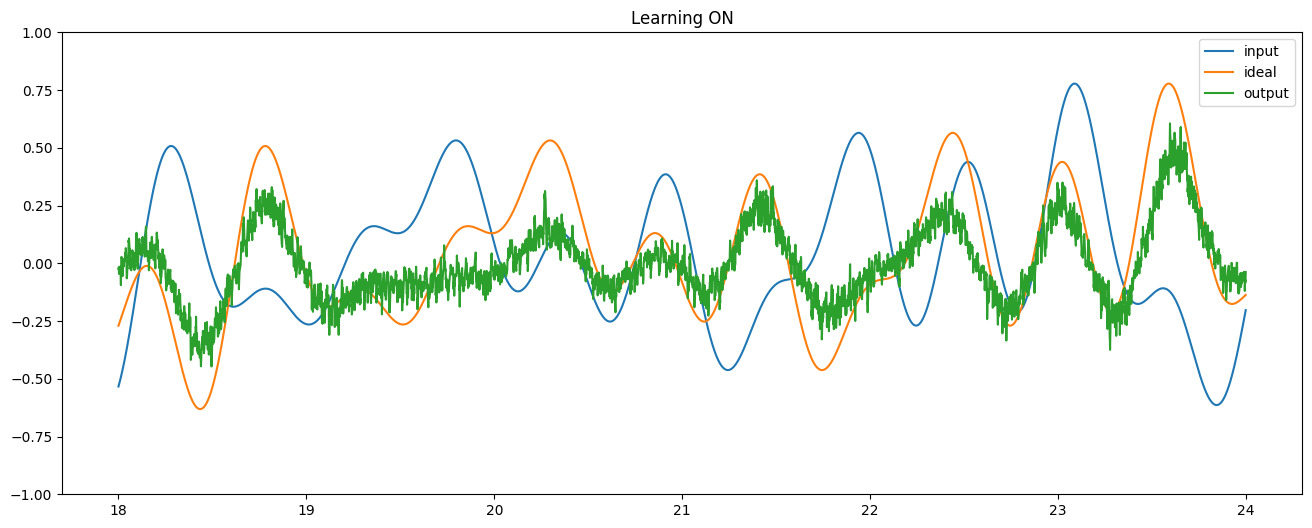

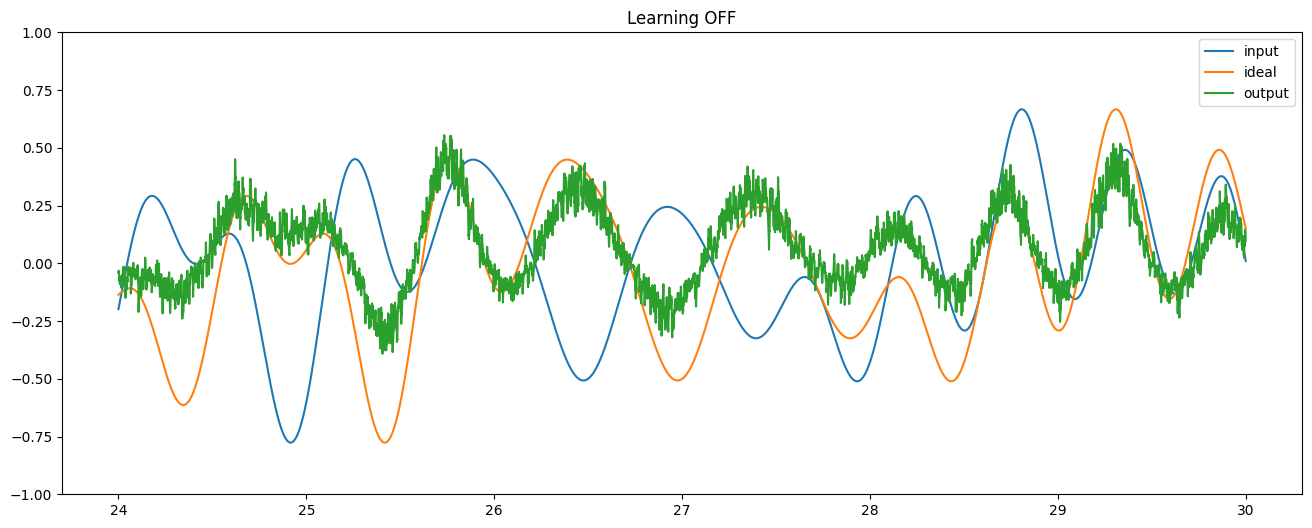

In [14]:
model = nengo_loihi.builder.Model(dt=dt)
model.pes_error_scale = 200.0
with nengo_loihi.Simulator(net, model=model) as sim:
    sim.run(sim_t)

# we'll break up the output into multiple plots, just for
# display purposes
t_per_plot = 6
for i in range(sim_t // t_per_plot):
    plot_slice = (sim.trange() >= t_per_plot * i) & (
        sim.trange() < t_per_plot * (i + 1)
    )

    plt.figure(figsize=(16, 6))
    plt.plot(sim.trange()[plot_slice], sim.data[p_stim][plot_slice], label="input")
    plt.plot(sim.trange()[plot_slice], sim.data[p_ideal][plot_slice], label="ideal")
    plt.plot(sim.trange()[plot_slice], sim.data[p_out][plot_slice], label="output")
    if i * t_per_plot < sim_t * 0.8:
        plt.title("Learning ON")
    else:
        plt.title("Learning OFF")
    plt.ylim([-1, 1])
    plt.legend()